# CS597 PA1 Implement Multi-Layer Perceptron Using PyTorch (100 pts)

### Description
In this Programming Assignment (PA), we aim to get familiar with the PyTorch framework.
Specifically, we need to complete the coding tasks in the Jupyter Notebook Download Jupyter Notebook(the points for each part are clearly stated).
After completing the tasks, please export the notebook as a PDF file and submit both the PDF file and the notebook to Canvas.

In [1]:
# Import necessary libraries
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import tqdm

/home/adam-torek/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the MNIST dataset

In [2]:
# Load MNIST dataset
# ref: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# train data
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test data
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Examine your model on the MNIST dataset

In [50]:
# Build your Multi-Layer Perceptron (MLP) model (20 pts)

class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        # TODO: build layers here
        self.flatten = torch.nn.Flatten()
        self.inp = torch.nn.Linear(in_features=input_size, out_features=hidden_size)
        self.act1 = torch.nn.Sigmoid()
        self.hid = torch.nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.act2 = torch.nn.Sigmoid()
        self.out = torch.nn.Linear(in_features=hidden_size, out_features=output_size)
        self.lastout = torch.nn.Softmax(dim=0)

    def forward(self, x):
        # TODO: build the networks
        in_res = self.inp(self.flatten(x))
        hid_res = self.hid(self.act1(in_res))
        out_res = self.out(self.act2(hid_res))
        return self.lastout(out_res)


In [51]:
# Instantiate the MLP model (10 pts)

# Gather all possible image classes
class_set = set()
for _, image_class in iter(train_dataset):
    class_set.add(image_class)

first_data = next(iter(train_dataset)) # Get the first image of the dataset
input_size = first_data[0].flatten().size()[0]  # what's input size? hints: flattened size for one instance
hidden_size =  100 # define on your own
output_size = len(class_set)  # what's output size for this classification tasks?
mlp_model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size)


In [55]:
# Define the loss function and optimizer (10 pts)

learning_rate = 0.001 # define your own learning rate here
loss_fn = torch.nn.CrossEntropyLoss()  # which loss function should we use here?
optimizer = torch.optim.Adam(params=mlp_model.parameters(), lr=learning_rate)  # which optimizer do you use?
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [54]:
# Train the model (30 pts)

def train(train_loader, num_epochs):
    """Train the model."""
    # TODO: finish the train loop here
    
    model_to_train = mlp_model.to(device)
    for _ in range(0, num_epochs):
        for inputs, labels in tqdm.tqdm(train_loader):
            optimizer.zero_grad()
            inputs = inputs.to(device) 
            labels = labels.to(device)
            outputs = model_to_train(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()


num_epochs = 10  # feel free to change the number of training epochs
train(train_loader, num_epochs)


100%|██████████| 938/938 [00:05<00:00, 159.78it/s]


In [70]:
# Evaluation by test accuracy (10 pts)

def evaluation(test_loader):
    """Evaluate the model on the test data."""
    # TODO: finish the evaluation function and print out the test accuracy.
    with torch.no_grad():
        model = mlp_model.to(device)
        total_correct = 0
        total_seen = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted_labels = torch.argmax(outputs, dim=1)
            total_correct += (predicted_labels == labels).sum()
            total_seen += labels.size(0)

        total_accuracy = total_correct / total_seen
        print("The evaluation accuracy on the test dataset is %.3f percent" % total_accuracy)

evaluation(test_loader)


The evaluation accuracy on the test dataset is 0.971 percent


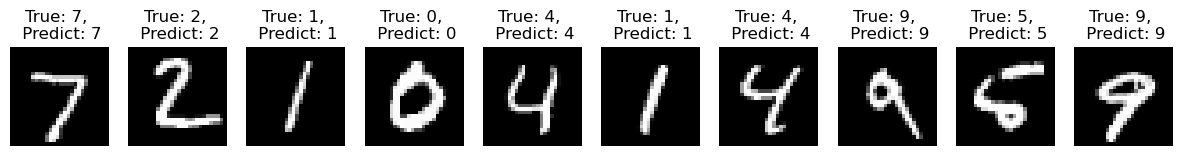

In [9]:
# Visualization (20 pts)

def prediction(data):
    """Make predictions on the given dataset."""
    # TODO: finish the prediction function and return the predicted labels.
    return predictions

def visualization(data, labels, num_data=10):
    """Visualize the given data and its prediction."""
    # make predictions
    predictions = prediction(data)
    # TODO: plot the instances with true/predicted labels (in the title).

# Load a batch of test data
data, labels = next(iter(test_loader))

# Visualize 10 test instances
num_data = 10
assert num_data <= batch_size
visualization(data, labels, num_data)
